In [1]:
import pickle
import random
from random import seed, randrange, shuffle
from collections import defaultdict

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import threading
import time

In [2]:
CARD_VALUES = {
    'A' : 11,
    '2' : 2,
    '3' : 3,
    '4' : 4,
    '5' : 5,
    '6' : 6,
    '7' : 7,
    '8' : 8,
    '9' : 9,
    '10': 10,
    'J' : 10,
    'Q' : 10,
    'K' : 10
}

In [3]:
ACTION_STAND     = 0
ACTION_HIT       = 1
ACTION_DOUBLE    = 2
ACTION_SPLIT     = 3
ACTION_SURRENDER = 4

In [4]:
with open("basic_strategy/basic_strategy.bin", 'rb') as f:
    BASIC_STRATEGY = pickle.load(f)

In [16]:
def bj_rules(rules = {}):
    num_decks = rules.get("num_decks", 8)
    return {
        "capacity"               : rules.get("capacity",                8),
        "num_decks"              : rules.get("num_decks",               8),
        "deck_penetration"       : rules.get("deck_penetration",        num_decks/(num_decks + 1)),
        "min_bet"                : rules.get("min_bet",                 1),
        "max_bet"                : rules.get("max_bet",                 None),
        "payout"                 : rules.get("payout",                  3/2),
        "hit_soft_17"            : rules.get("hit_soft_17",             True),
        "insurance"              : rules.get("insurance",               False),
        "surrender"              : rules.get("surrender",               False),
        "early_surrender"        : rules.get("early_surrender",         False),
        "double_after_split"     : rules.get("double_after_split",      True),
        "dealer_hidden_card"     : rules.get("dealer_hidden_card",      True),
        "dealer_checks_blackjack": rules.get("dealer_checks_blackjack", True)
    }

def create_deck(num_decks=1):
    return list(CARD_VALUES.keys())*4*num_decks

def validate_action(action, actions):
    assert action in actions
    return action

def basic_strategy_actions(strategy, hand, dealer_card, params = bj_rules()):
    dealer_value = CARD_VALUES[dealer_card]
    if len(hand) == 2 and hand[0] == hand[1] and CARD_VALUES[hand[0]] in strategy["split"]:
        card_value = CARD_VALUES[hand.cards[0]]
        actions = []
        for action in strategy["split"][card_value][dealer_value]:
            if action == 5:
                if params["double_after_split"]: # Split only if double can occur after
                    actions.append(ACTION_SPLIT)
            else:
                actions.append(action)
        return actions
    return [a for a in strategy["soft" if hand.is_soft else "hard"][hand.value][dealer_value]]

In [6]:
class Hand:
    def __init__(self, bet=0):
        self.bet = bet
        self.cards = []
        self.is_soft = False
        self.value = 0
        self.payout = 0
        self.split_level = 0
        self.surrendered = False
        
        
    def deal(self, card):
        self.cards.append(card)
        self.value += CARD_VALUES[card]
        if card == 'A':
            if self.value <= 21:
                self.is_soft = True
            else:
                self.value -= 10
        if self.value > 21 and self.is_soft:
            self.is_soft = False
            self.value -= 10
    
    
    def clear(self):
        self.cards.clear()
        self.is_soft = False
        self.value = 0
        self.win = False
        
        
    def is_blackjack(self):
        return self.value == 21 and len(self.cards) == 2
        
        
    def split(self):
        assert len(self.cards) == 2
        
        # Get the original two cards
        l, r = self.cards
        
        # Re-deal this hand
        self.clear()
        self.deal(l)
        
        # Create a new hand a deal the other card
        hand = Hand(self.bet)
        hand.deal(r)
        
        # Update the split level
        self.split_level = hand.split_level = hand.split_level + 1
        
        return hand
    
    
    def __getitem__(self, i):
        return self.cards[i]
    

    def __int__(self):
        return self.value
    
    
    def __eq__(self, other):
        return int(self) == int(other)
    
    
    def __ge__(self, other):
        return int(self) >= int(other)
    
    
    def __gt__(self, other):
        return int(self) > int(other)
    
    
    def __le__(self, other):
        return int(self) <= int(other)
    
    
    def __lt__(self, other):
        return int(self) < int(other)
    
    
    def __len__(self):
        return len(self.cards)
    
    
    def __str__(self):
        return f"({self.value}{'S'*self.is_soft}) " + " ".join([f"[{card}]" for card in self.cards])

# Players

The different player types are created here

## Abstract Player

The base player class

In [7]:
class Player:
    def __init__(self, bankroll=0):
        self.table = None
        self.bankroll = bankroll
        self.hands = None
        self.prev_bets = []
        self.card_count = 0
        self.true_card_count = 0
        self.wins = 0
        self.games = 0
        self.outcome_map = {
            "cc": defaultdict(lambda: [0, 0]),  # Card count
            "tcc": defaultdict(lambda: [0, 0])} # True card count
        
    def place_bets(self, min_bet, max_bet, max_hands):
        pass
    
    def early_surrender(self, hand, dealer_card):
        """
        Surrender early before Dealer checks for blackjack if the table allows it
        Return True to surrender; otherwise False
        """
        return False
    
    def play(self, hand, actions, dealer_card):
        """
        It's your turn. You are given the list of actions you can make
        Return the action you would like to make
        """
        return ACTION_STAND
    
    def on_join(self, table):
        self.table = table
    
    def on_begin(self):
        self.card_count = self.table.card_count
        self.true_card_count = int(self.card_count / (self.table.rules["num_decks"] - self.table.cards_dealt//52))
    
    def on_end(self, dealer_hand):
        for hand in self.hands:
            self.games += 1
            self.outcome_map["cc"][self.card_count][1] += 1
            self.outcome_map["tcc"][self.true_card_count][1] += 1
            if hand.payout >= hand.bet:
                self.wins += 1
                self.outcome_map["cc"][self.card_count][0] += 1
                self.outcome_map["tcc"][self.true_card_count][0] += 1
                
    def plot(self):
        for k, m in self.outcome_map.items():
            fig, ax = plt.subplots()
            x = sorted(m.keys())
            y = np.array([m[i][0] for i in x]) / np.array([m[i][1] for i in x])
            ax.bar(x, y)
            ax.set_ylabel("Win Probability")
            ax.set_xlabel("Card Count" if k == "cc" else "True Card Count")
            plt.axhline(y=1/self.table.rules["payout"], color='g', label="Break Even")
            plt.axhline(y=0.5, color='grey', label="50 Percent Probability")
            plt.axhline(y=self.wins/self.games, color='r', linestyle='--', label="Average Win Probability")
            ax.legend()
            fig.tight_layout()
            plt.show()

## Human Player

A simple player implementation for a human to play

In [8]:
class HumanPlayer(Player):
    def place_bets(self, min_bet, max_bet, max_hands):
        print(f"Enter space separated bet list: (min/max: {min_bet}/{max_bet}). Max number of hands: {max_hands}")
        bets = list(map(int, input().split()))
        assert sum(bets) <= self.bankroll, "Not enough in bankroll"
        for bet in bets:
            assert min_bet <= bet, "Did not meet minimum bet requirement"
            if max_bet is not None:
                assert bet <= max_bet, "Exceeded maximum bet requirement"
        return bets
    
    def early_surrender(self, hand, dealer_card):
        print(f"Dealer Card: ({CARD_VALUES[dealer_card]}) [{dealer_card}]")
        print(f"Your hand:", str(hand))
        return input("Would you like to surrender [y/n]: ").lower() == 'y'
        
    def play(self, hand, actions, dealer_card):
        print(f"Dealer Card: ({CARD_VALUES[dealer_card]}) [{dealer_card}]")
        print(f"Your hand:", str(hand))
        print("\nActions:")
        for action in actions:
            print(f"{action}:", ["Stand", "Hit", "Double", "Split", "Surrender"][action])
        return int(input())
    
    def on_end(self, dealer_hand):
        super(HumanPlayer, self).on_end(dealer_hand)
        print("Finished!")
        print(f"Dealer Hand:", str(dealer_hand))
        for i, hand in enumerate(self.hands):
            print(f"{i}: {str(hand)}; {hand.surrendered and 'Surrendered; '}Payout: {hand.payout}; Profit: {hand.payout - hand.bet}")
        print(f"Bankroll: {self.bankroll}")

In [9]:
class BasicStrategyPlayer(Player):
    def __init__(self, bankroll=0):
        super(BasicStrategyPlayer, self).__init__(bankroll)
        self.strategy = None
        
    def on_join(self, table):
        super(BasicStrategyPlayer, self).on_join(table)
        hit_soft_17 = table.rules["hit_soft_17"]
        self.strategy = BASIC_STRATEGY[f"{'hit' if hit_soft_17 else 'stand'}_soft_17"]
    
    def place_bets(self, min_bet, max_bet, max_hands):
        return [1]
    
    def play(self, hand, actions, dealer_card):
#         print(f"Dealer Card: ({CARD_VALUES[dealer_card]}) [{dealer_card}]")
#         print("My Hand:", str(hand))
        for a in basic_strategy_actions(self.strategy, hand, dealer_card, self.table.rules):
            if a in actions:
#                 print("Performing Action:", a)
                return a
        # Should never reach here, but just in case
#         print("ERROR")
        return ACTION_STAND

In [10]:
class Blackjack:
    def __init__(self, rules = {}):
        self.rules = bj_rules(rules)
        
        self.hand = Hand()
        self.players = []
        self.card_count = 0
        self.cards_dealt = 0
        self.hidden_card = None
        
        self.action_map = {
            ACTION_HIT      : self.action_hit,
            ACTION_DOUBLE   : self.action_double,
            ACTION_SPLIT    : self.action_split,
            ACTION_SURRENDER: self.action_surrender
        }
        
        self.reset()
        
        
    def reset(self):
        # Create the deck of shuffled cards
        self.deck = create_deck(self.rules["num_decks"])
        shuffle(self.deck)
        
        # Reset the card count
        self.card_count = 0
        self.cards_dealt = 0
        
        
    def deal(self, hand, card=None):
        # Check if we are dealing a specific card, otherwise fetch one from the deck
        if card is None:
            card = self.deck.pop()
        
        # Count cards
        self.card_count += -1 if CARD_VALUES[card] > 9 else int(CARD_VALUES[card] < 7)
        self.cards_dealt += 1
        
        # Deal the card to the hand
        hand.deal(card)
        
        
    def play(self):
        
        # Make sure there are enough players
        assert len(self.players) > 0
        
        # If the card count has exceeded the penetration limit, reshuffle
        if self.cards_dealt/52/self.rules["num_decks"] >= self.rules["deck_penetration"]:
            self.reset()
        
        for player in self.players:
            player.on_begin()
        
        # Have each player place their bets
        self.place_bets()
        
        # Deal everyone their cards
        self.deal_players()
        
        if self.rules["dealer_checks_blackjack"]:
            if self.rules["surrender"] and self.rules["early_surrender"]:
                self.early_surrender()
        
        # If the dealer doesn't have blackjack, let the players play
        if not (self.rules["dealer_checks_blackjack"] and self.hand.is_blackjack()):
            # Each player plays their turn
            self.play_turns()
        
        # Evaluate all player's results
        self.evaluate()
        
        for player in self.players:
            player.on_end(self.hand)
        
        # Clear the table
        self.clear()
        
        
    def place_bets(self):
        for player in self.players:
            max_hands = 1 + self.rules["capacity"] - len(self.players)
            bets = player.place_bets(self.rules["min_bet"], self.rules["max_bet"], max_hands)
            player.hands = [Hand(bet) for bet in bets]
            player.bankroll -= sum(bets)
            
            
    def deal_players(self):
        # Deal players their cards
        for i in range(2):
            # Deal each player a card
            for player in self.players:
                for hand in player.hands:
                    self.deal(hand)
            
            # Deal the dealer their cards
            if i == 0:
                self.deal(self.hand)
        # Deal the dealer their hidden card
        if self.rules["dealer_hidden_card"]:
            self.hidden_card = self.deck.pop()
                
                
    def early_surrender(self):
        for player in self.players:
            for i, hand in enumerate(player.hands):
                if player.early_surrender(hand, self.hand[0]):
                    self.action_surrender(player, i, hand)
            
            
    def play_turns(self):
        all_dead_hands = True # Indicate if all players have surrendered/busted
        for player in self.players:
            all_dead_hands &= self.play_player(player) == 0
        
        # If there are no playable hands, end the round early
        if all_dead_hands:
            return
        
        # If the dealer didn't get the hidden card, deal one now and check for blackjack
        if self.rules["dealer_hidden_card"]:
            self.deal(self.hand, self.hidden_card)
            self.hidden_card = None
        else:
            self.deal(self.hand)
            if self.hand.is_blackjack():
                return
            
        while self.hand < 17 or ( self.hand == 17 and self.hand.is_soft and self.rules["hit_soft_17"]):
            self.deal(self.hand)
            
            
    def play_player(self, player):
        dead_hands = 0
        i = 0
        while i < len(player.hands):
            hand = player.hands[i]
            if not hand.surrendered:
                if len(hand) == 1: # If the player previously split, they need a new card
                    self.deal(hand)
                if hand < 21: # Check for blackjack
                    if self.play_hand(player, i, hand) == ACTION_SPLIT:
                        continue # If the player splits, avoid recursion
                if hand.surrendered:
                    dead_hands += 1
            else:
                dead_hands += 1
            i += 1
        # Return the number of playable hands
        return len(player.hands) - dead_hands
    
            
    def play_hand(self, player, i, hand):
        # Initial list of possible actions
        init_actions, actions = set(), set((ACTION_HIT, ACTION_STAND))
        if len(hand) == 2:
            if self.rules["surrender"] and not self.rules["early_surrender"]:
                init_actions.add(ACTION_SURRENDER)
            if player.bankroll >= hand.bet:
                init_actions.add(ACTION_DOUBLE)
                if hand[0] == hand[1]:
                    init_actions.add(ACTION_SPLIT)
                
        # Play as long as the player is hitting
        action = self.action(player, i, hand, init_actions | actions)
        while hand < 21 and action == ACTION_HIT:
            action = self.action(player, i, hand, actions)
        return action
    
    
    def action(self, player, i, hand, actions):
        action = validate_action(player.play(hand, actions, self.hand[0]), actions)
        if action in self.action_map:
            self.action_map[action](player, i, hand)
        return action
    
    
    def action_hit(self, player, i, hand):
        self.deal(hand)
        
    
    def action_double(self, player, i, hand):
        self.deal(hand)
        player.bankroll -= hand.bet
        hand.bet += hand.bet
        
    
    def action_split(self, player, i, hand):
        player.hands.insert(i+1, hand.split())
        player.bankroll -= hand.bet
        
        
    def action_surrender(self, player, i, hand):
        hand.surrendered = True
        hand.payout = hand.bet / 2
    
    
    def evaluate(self):
        for player in self.players:
            for hand in player.hands:
                if not hand.surrendered:
                    if self.hand > 21 or hand.is_blackjack():
                        # Dealer busted or player got a blackjack
                        hand.payout = hand.bet*self.rules["payout"]
                    elif hand <= 21 and not self.hand.is_blackjack():
                        # Player didn't bust and the dealer didn't have a blackjack, reward the player if necessary
                        if hand > self.hand: # Player wins
                            hand.payout = hand.bet*self.rules["payout"]
                        elif hand == self.hand: # Push occurred
                            hand.payout = hand.bet
                player.bankroll += hand.payout
                            

    def clear(self):
        self.hand.clear()
        for player in self.players:
            del player.hands
            
            
    def add_player(self, player: Player):
        assert len(self.players) < self.rules["capacity"]
        self.players.append(player)
        player.on_join(self)

# Testing

## Hit Soft-17

This test validates the "hit soft-17" parameter

In [11]:
seed(1) # Deals out a couple of aces to the dealer

In [12]:
bj = Blackjack({
    "dealer_hidden_card": True,
    "hit_soft_17": False
})
player = HumanPlayer(1000)
bj.add_player(player)

In [13]:
bj.play() # stand on first move

Enter space separated bet list: (min/max: 1/None). Max number of hands: 8


 1


Dealer Card: (3) [3]
Your hand: (19) [9] [J]

Actions:
0: Stand
1: Hit
2: Double


 0


Finished!
Dealer Hand: (18S) [3] [A] [4]
0: (19) [9] [J]; FalsePayout: 1.5; Profit: 0.5
Bankroll: 1000.5


## Dealer Blackjack

This test validates the cases where a dealer receives a blackjack (with and without hidden card)

In [15]:
seed(30) # Deals a blackjack to the dealer

In [16]:
bj = Blackjack({
    "dealer_checks_blackjack": True,
    "dealer_hidden_card": True
})
player = HumanPlayer(1000)
bj.add_player(player)

In [17]:
bj.play() # stand on first move

Enter space separated bet list: (min/max: 1/None). Max number of hands: 8


Finished!
Dealer Hand: (9) [9]
Bankroll: 1000


## Split

In [18]:
seed(35) # Deal the player two Jacks

In [19]:
bj = Blackjack({
    "dealer_checks_blackjack": True,
    "dealer_hidden_card": False
})
player = HumanPlayer(1000)
bj.add_player(player)

In [20]:
bj.play() # Split, stand, stand

Enter space separated bet list: (min/max: 1/None). Max number of hands: 8


Finished!
Dealer Hand: (10) [J]
Bankroll: 1000


## Surrender

In [37]:
seed(40) # Deal the player two Jacks

In [38]:
bj = Blackjack({
    "dealer_checks_blackjack": True,
    "dealer_hidden_card": False,
    "surrender": True,
    "early_surrender": False
})
player = HumanPlayer(1000)
bj.add_player(player)

In [39]:
bj.play() # Surrender

Enter space separated bet list: (min/max: 1/None). Max number of hands: 8


 1


Dealer Card: (6) [6]
Your hand: (16S) [A] [5]

Actions:
0: Stand
1: Hit
2: Double
4: Surrender


 4


Finished!
Dealer Hand: (6) [6]
0: (16S) [A] [5]; Surrendered; Payout: 0.5; Profit: -0.5
Bankroll: 999.5


## Other Testing

In [11]:
def basic_strategy_benchmark(rules={}, num_players=1, epochs=1, seed=None, num_threads=1):
    def run(epochs, players, lock=None):
        bj = Blackjack(rules)
        for i in range(num_players):
            bj.add_player(BasicStrategyPlayer(1000) if num_threads > 1 else players[i])
        s = time.time()
        for i in range(epochs):
            bj.play()
        print("Time to play", epochs, f"was {time.time() - s:.2f}")
        if lock:
            lock.acquire()
        for i in range(num_players):
            players[i].wins += bj.players[i].wins
            players[i].games += bj.players[i].games
        if lock:
            lock.release()
    if seed is not None:
        random.seed(seed)
    players = [BasicStrategyPlayer(1000) for p in range(num_players)]
    s = time.time()
    if num_threads > 1:
        lock = threading.Lock()
        threads = []
        epochs_per_thread = epochs//num_threads
        remaining = epochs%num_threads
        for i in range(num_threads):
            threads.append(threading.Thread(target=run, args=(epochs_per_thread + (i < remaining), players, lock)))
            threads[i].start()
        print("Running", num_threads, "threads...")
        for i in range(num_threads):
            threads[i].join()
            print("Thread", i, "finished")
    else:
        print("Running")
        run(epochs, players)
    print(f"Took {time.time() - s:.2f} seconds")
    return players

In [12]:
players = basic_strategy_benchmark({
    "num_decks": 8,
    "surrender": True
}, num_players=8, epochs=1000000, seed=1, num_threads=1)

# for p in players:
#     p.plot()

Running
Time to play 1000000 was 149.96
Took 149.96 seconds


In [13]:
for player in players:
    print(player.wins, player.wins/player.games, player.bankroll)

1071296 0.535577303795899 -205980.5
1071076 0.535437873117727 -206442.0
1073562 0.5367117641824205 -204386.5
1071420 0.5356200158373393 -205869.5
1071502 0.5356861819719814 -205548.0
1070494 0.5351619092564283 -206388.5
1071456 0.535643368347801 -205929.0
1069822 0.5348329143944984 -206933.5


Player 1


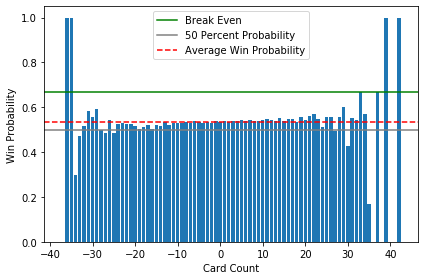

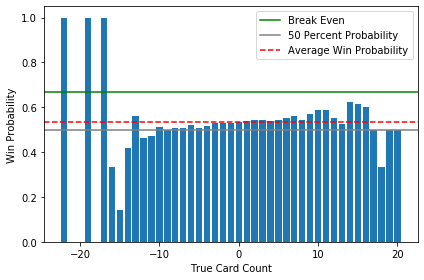

Player 2


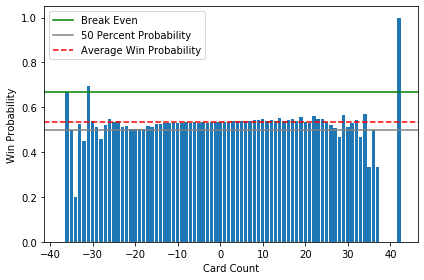

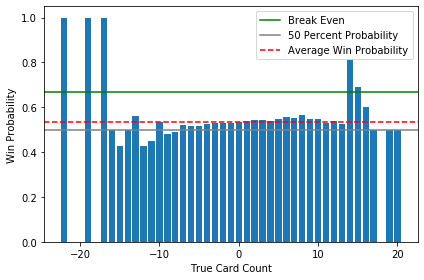

Player 3


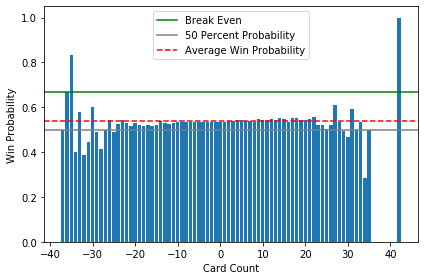

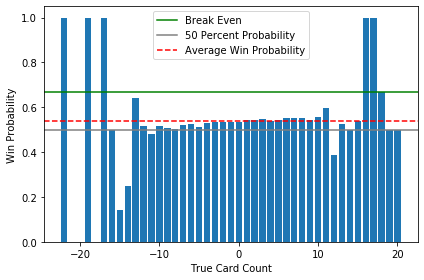

Player 4


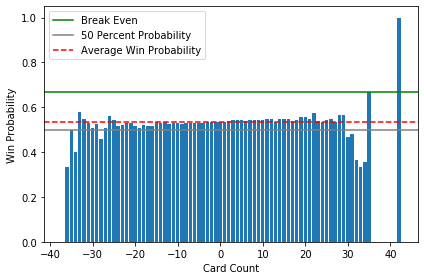

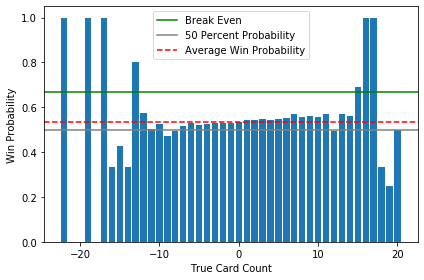

Player 5


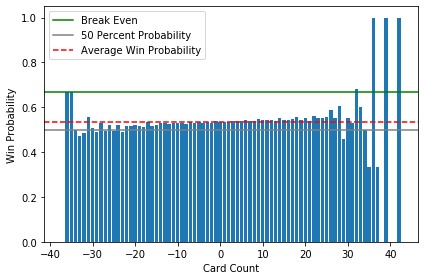

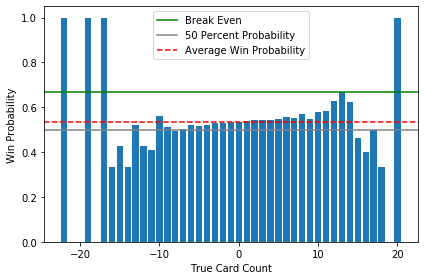

Player 6


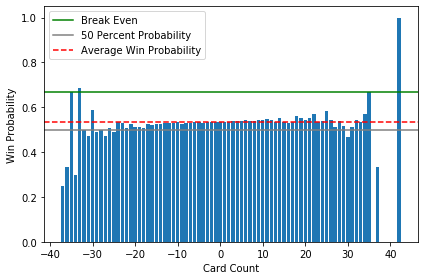

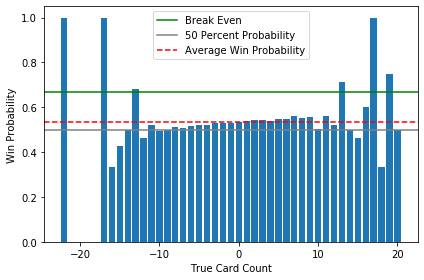

Player 7


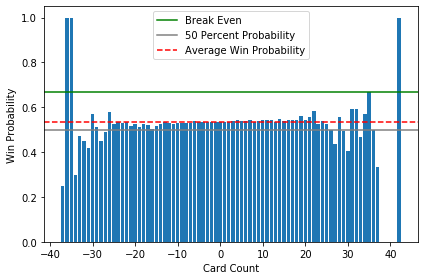

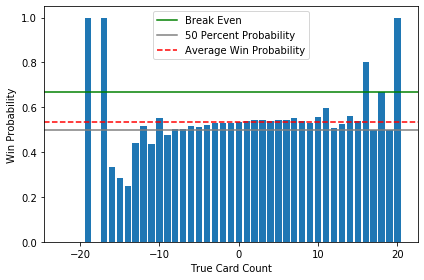

Player 8


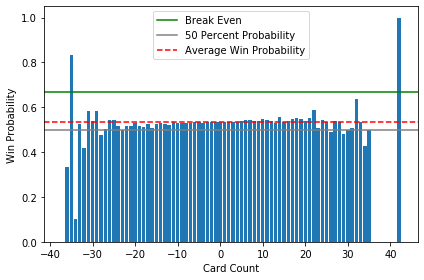

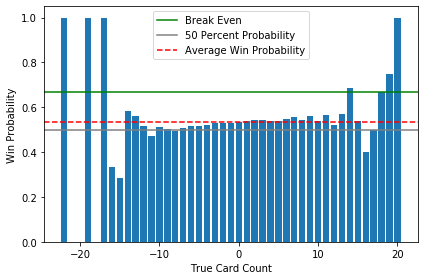

In [14]:
for i, player in enumerate(players):
    print("Player", i+1)
    player.plot()